## Vehicle Detection Project

The goals / steps of this project are the following:

Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
Optionally, can also apply a color transform and append binned color features, as well as histograms of color, to  the HOG feature vector.

For the above 2 steps normalize the features and randomize a selection for training and testing.

Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
Estimate a bounding box for vehicles detected.

In [20]:
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import glob
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline
# 1. load the database

# Divide up into cars and notcars
car_images = glob.glob('vehicles/*/*.png')
non_car_images = glob.glob('non-vehicles/*/*.png')

# Store all car image files 
cars = []

# Store all not car image files
notcars = []

for image in car_images:
    cars.append(image)
for image in non_car_images:
    notcars.append(image)

print("Total car images ", len(cars))
print("Total non-car images ", len(notcars))

Total car images  8792
Total non-car images  8968


In [22]:

'''
Define a function to return HOG features
'''
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


### 1. Histogram of Oriented Gradients (HOG)

The computed gradient magnitudes and direction at each pixel has groupd into small cell of size 8(here) and each has 8 pixels. Inside each cell a histogram of gradient directions or orientations from each 64 pixes with in the cell and these samples are distributed within 9(here) orientation bins and sum the samples per bin. Each pixel in the image gets a vote in which histogram bin it belongs to.

From line 36 to 64 I extracted the HOG for a car and non-car image and visualized it from line 67 to 100 bellow.


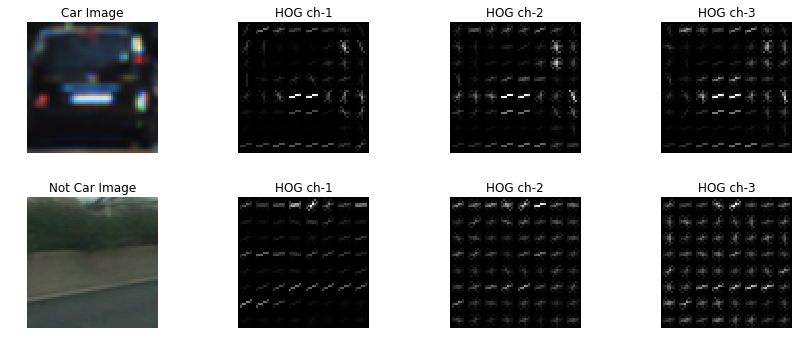

In [23]:

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
ind_notcar = np.random.randint(0, len(notcars))
# Read in the image
#print(cars[ind])

# Read png image in the scale of 0 to 1.
image = mpimg.imread(cars[ind])


# Read png image in the scale of 0 to 1
not_car_image = mpimg.imread(notcars[ind_notcar])

feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
feature_notcar_image = cv2.cvtColor(not_car_image, cv2.COLOR_RGB2YCrCb)
#print(feature_image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#feature_image = feature_image.astype(np.float32)/255
#feature_notcar_image = feature_notcar_image.astype(np.float32)/255
#print(feature_image)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features0, hog_image0 = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Call our function with vis=True to see an image output
features1, hog_image1 = get_hog_features(feature_image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Call our function with vis=True to see an image output
features2, hog_image2 = get_hog_features(feature_image[:,:,2], orient, 
                        pix_per_cell, cell_per_block,
                        vis=True, feature_vec=False)

# not car
# Call our function with vis=True to see an image output
not_car_features0, not_car_hog_image0 = get_hog_features(feature_notcar_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Call our function with vis=True to see an image output
not_car_features1, not_car_hog_image1 = get_hog_features(feature_notcar_image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Call our function with vis=True to see an image output
not_car_features2, not_car_hog_image2 = get_hog_features(feature_notcar_image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


fig, axs = plt.subplots(2,4, figsize=(12,5))
axs = axs.ravel()
axs[0].axis('off')
axs[0].set_title('Car Image')
axs[0].imshow(image)

axs[1].axis('off')
axs[1].set_title('HOG ch-1')
axs[1].imshow(hog_image0, cmap='gray')

axs[2].axis('off')
axs[2].set_title('HOG ch-2')
axs[2].imshow(hog_image1, cmap='gray')

axs[3].axis('off')
axs[3].set_title('HOG ch-3')
axs[3].imshow(hog_image2, cmap='gray')

axs[4].axis('off')
axs[4].set_title('Not Car Image')
axs[4].imshow(not_car_image)

axs[5].axis('off')
axs[5].set_title('HOG ch-1')
axs[5].imshow(not_car_hog_image0, cmap='gray')

axs[6].axis('off')
axs[6].set_title('HOG ch-2')
axs[6].imshow(not_car_hog_image1, cmap='gray')

axs[7].axis('off')
axs[7].set_title('HOG ch-3')
axs[7].imshow(not_car_hog_image2, cmap='gray')
fig.tight_layout()


### 2. Spatial Binning of Color 

Template matching is not a particularly robust method for finding vehicles unless we know exactly what the target object looks like. However, raw pixel values are still quite useful to include in  feature vector in searching for cars.

While it could be cumbersome to include three color channels of a full resolution image, we can perform spatial binning on an image and still retain enough information to help in finding vehicles.

As can be seen in the example bellow, even going all the way down to 32 x 32 pixel resolution, the car itself is still clearly identifiable by eye, and this means that the relevant features are still preserved at this resolution. The Feature vectors for car and non-car images are illustrated on line 31 to 48 bellow.

Also by visualization I observed binned color features are quite different between car and non-car image when using color 'YCrCb' and is a better selection in this case.  


In [24]:
'''
Define a function to compute binned color features using cv2.resize and then 
flattened the array using ravel
Return the horizontally stacked feature vector.
'''
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

[ 0.06566275  0.06404314  0.06412746 ...,  0.45049018  0.45695022
  0.49946752]


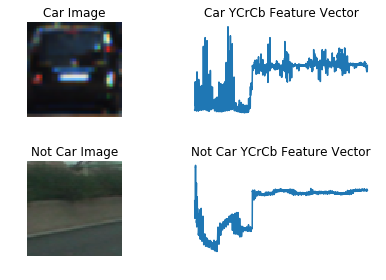

In [25]:
# Visualize Spatially Binned Features

def convert_feature_color(img, color_space = 'RGB'):
    if color_space == 'RGB':
        feature_image = np.copy(img)
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if color_space == 'LUV':
        #print("Hit LUV")
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return feature_image


color_space = 'YCrCb'
image_vec = convert_feature_color(image, color_space)
feature_vec = bin_spatial(image_vec, size=(32, 32))
#feature_vec = feature_vec.astype(np.float32)/255

not_car_image_vec = convert_feature_color(not_car_image, color_space)
ncar_feature_vec = bin_spatial(not_car_image_vec, size=(32, 32))
#ncar_feature_vec = ncar_feature_vec.astype(np.float32)/255

print(feature_vec)

fig, axs = plt.subplots(2,2)
axs = axs.ravel()
axs[0].axis('off')
axs[0].set_title('Car Image')
axs[0].imshow(image)

axs[1].axis('off')
axs[1].set_title('Car %s Feature Vector'%format(color_space))
axs[1].plot(feature_vec)

axs[2].axis('off')
axs[2].set_title('Not Car Image')
axs[2].imshow(not_car_image)

axs[3].axis('off')
axs[3].set_title('Not Car %s Feature Vector'%format(color_space))
axs[3].plot(ncar_feature_vec)
fig.tight_layout()

### 3. Histograms of pixel intensity (color histograms) as features 

Image template is useful for detecting things those do not very in their appearance much such as fixed logos etc.
But in real world objects i.e. a running car appears in different forms and orientation. We can compute the histogram of color value with the idea that image location with similar color distribution will reveal a close match. Variance and different image size can also be accomodated by normalizing the histogram. Color histogram are shown bellow for car and non-car images. I used each color channel from color space YCrCb, Although I do not see a lot of difference between car and non-car image in this case.

In [26]:
'''
Define a function to compute color histogram features if Image is on scale 0 to 1,
need to convert that image to scale 0 to 255 before the image can be given to this function
'''
def color_hist(img, nbins=32, bins_range=(0, 256), individual_histogram=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0: len(bin_edges) -1])/2
    #hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    if individual_histogram == True:
        # Return the individual histograms, bin_centers and feature vector
        return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
    
    return hist_features


Car image vehicles/KITTI_extracted/3529.png color histogram


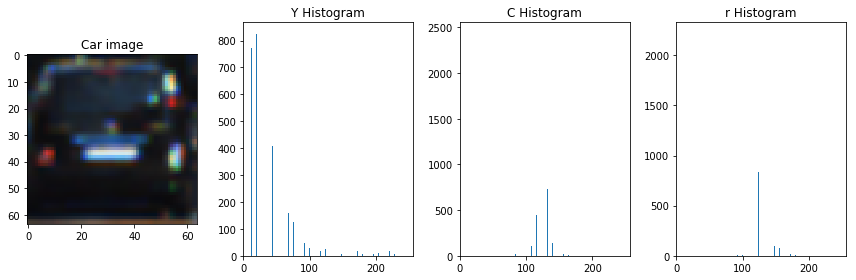

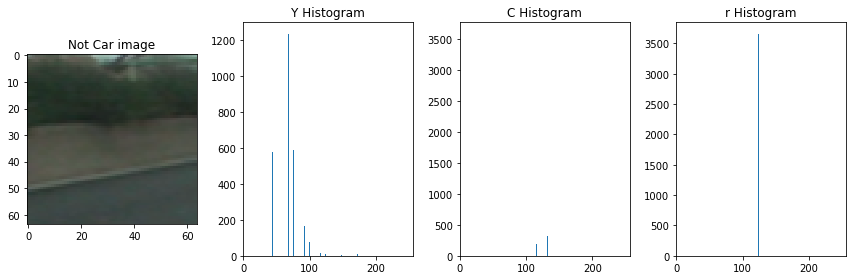

In [27]:
# Visualize individual histograms of colors

def draw_histogram(image, bincen, rh, gh, bh, color_space='RGB', image_title='Car'):
    # Plot a figure with all three bar charts
    if rh is not None:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(141)
        plt.imshow(image)
        plt.title('%s image'%format(image_title))
        plt.subplot(142)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title('%s Histogram'%format(color_space[0]))
        plt.subplot(143)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title('%s Histogram'%format(color_space[1]))
        plt.subplot(144)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title('%s Histogram'%format(color_space[2]))
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')

# car image
color_space = 'YCrCb'
color_image = convert_feature_color(image, color_space)

# convert the image to 0 to 255 scale.
car_image = color_image.astype(np.float32)*255
print("Car image %s color histogram"%format(cars[ind]))
rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=32, bins_range=(0, 256), individual_histogram=True)
draw_histogram(image, bincen, rh, gh, bh, color_space, image_title='Car')

# non car image 
not_car_color_image = convert_feature_color(not_car_image, color_space)
n_car_image = not_car_color_image.astype(np.float32)*255
rh, gh, bh, bincen, feature_vec = color_hist(n_car_image, nbins=32, bins_range=(0, 256), individual_histogram=True)
draw_histogram(not_car_image, bincen, rh, gh, bh, color_space, image_title='Not Car')



In [28]:
'''
Define a function to extract features from a list of images
Have this function call bin_spatial() and color_hist()
'''
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            # Apply Spatial Binning
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

print("extract_features done")

extract_features done


In [29]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

### 4. Train  a classifier using selected HOG features and other features

I use the color space 'YCrCb' with 12 orientation, 8 pixel per cell and 2 cell per block and use all channel of the color space to extract 3 features i.e HOG, Spatial Binning (resize the image to 32x32) and color histogram  
and use the provided car and non-car images, vertically (rowwise) stack them and use sklean StandardScaler function to standardize features by removing the mean and scaling to unit variance, it is important to do so as large sigma/variance means high opinionated and small variance means more uncertainity and it is hard to train in both cases. Normalizing ensures that classifier's behavior isn't dominated by just a subset of the features, and that the training process is as efficient as possible. Once called the  X_scaler.transform(X), scaled_X has the 
normalized feature vector.
Then I split up data into randomized training and test sets (20% split) in line 37,38 bellow. Testing the classifier on a separate dataset will prevent against overfitting and provide a more realistic estimate of accuracy and error while random shuffling ensures that ordering effects don't influence the classifier.
Also note that the number of feature for car and non car is 8792 and 8968 which is pretty  balance. Preparing a balanced dataset ensures that one class does not dominate the classifier's performance.

I used LUV (the L component has the range [0,100], the U component has the range [-134,220], and the V component has the range [-140,122]) and YUV(Y ranges from 0 to 1 (or 0 to 255 in digital formats), while U and V range from -0.5 to 0.5 (or -128 to 127 in signed digital form, or 0 to 255 in unsigned form)) color space, I noticed when using those above color space I had to set transform_sqrt=False when calling hog() for hog feature extraction as 
it causes an error(NaN) as the image contains negative values (because it's taking the square root of image values.

I tried with Naive base which was faster in training with an accuracy of 0.9516 and 2.57 seconds to train.
I tried with decision tree with default=”gini” for the Gini impurity and with default minimum split, it took long 
long time on my Mac with 2.2 GHz Intel Core i7 and 16 GB of ram. Then I change the minimum split to 50 (stop the tree growth at 50 child nodes) I got around 0.965 test accuracy.

Lastly I came back to color 'YCrCb', with Linear Support Vector Classifier and get a test accuracy of 0.9896 !


In [32]:

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()



car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

print('car_features: ', len(car_features) , 'notcar_features', len(notcar_features))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) #.reshape(1,-1)
print('X ', len(X) , 'scaled_X', scaled_X.shape, 'Y', y.shape)

# Randomized training data everytime the following 2 line executes and also 
# split the train and test sets in 20%
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('X_train', X_train.shape)

# Use a linear SVC 
clf = LinearSVC()
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

print('DONE')


car_features:  8792 notcar_features 8968
94.7 Seconds to extract HOG features...
X  17760 scaled_X (17760, 10224) Y (17760,)
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 10224
X_train (14208, 10224)
8.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
0.00136 Seconds to predict 10 labels with SVC
DONE


### 5.Sliding Window Search

I use the Hog Sub-sampling Window Search that was implemented in this course material which is an efficient one 
that allows to only have to extract the Hog features once. The function find_cars bellow able to both extract features and make predictions.I ran this same function multiple times for different scale values to generate multiple-scaled search windows.

In [33]:
'''
Convert an RGB image to the desired colore space i.e. COLOR_RGB2YCrCb etc.
'''
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

'''
find_cars function will extract features using hog sub-sampling, spatial bin and
color histogram and will make predictions. 
Return a list of detected boxes as part of the car detection on a given image
'''
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, \
              cell_per_block, spatial_size, hist_bins):
    
    # Initialize a list to append window positions to
    window_list = []
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))#.reshape(1,-1)
            #print("hog_features shape:", hog_features.shape)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get spatial bin features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            
            #Get color histogram feature  
            hist_features = color_hist(subimg, nbins=hist_bins)
        
            #print("spatial_features shape:", spatial_features.shape)
            #print("hist_features shape:", hist_features.shape)

            # Scale features and make a prediction
            total_feature = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #print("total_feature", total_feature.shape)
            test_features = X_scaler.transform(total_feature)    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                # Calculate window position
                startx = xbox_left
                endx = xbox_left+win_draw
                starty = ytop_draw+ystart
                endy = ytop_draw+win_draw+ystart
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
   
    return window_list

    

###### Following code implements a sliding window search and the images after it showcases the detection windows.
I use small scale of 1 for frames at far from the car as cars on those frame will be smaller than scale 1.5 for closer frame and even bigger scale of 2 for more closer frame. As see on the picture bellow , Red boxes are closer than Blue boxes than Green boxes from the car.

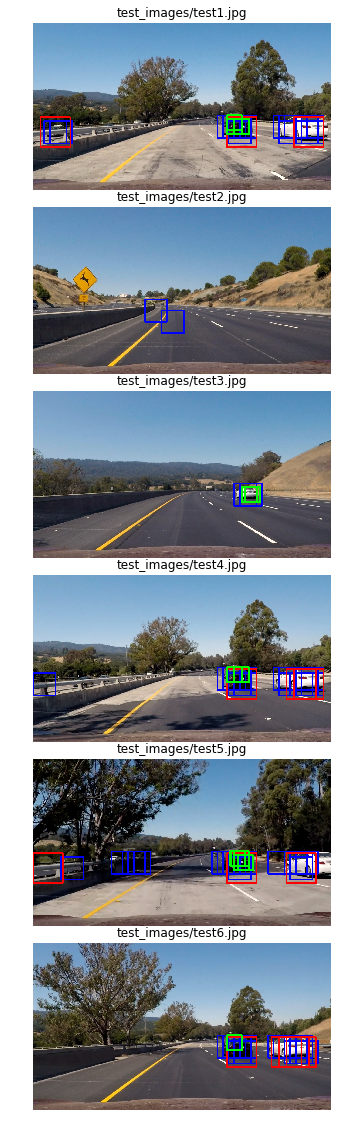

In [34]:

test_car_images = glob.glob('test_images/*.jpg')

spatial_size = (32,32)
hist_bins = 32

number_of_image = len(test_car_images)
fig, axs = plt.subplots(number_of_image, 1,figsize=(16,20))
fig.subplots_adjust(hspace = .1, wspace=.010)
axs = axs.ravel()
ix = 0
for img_file in test_car_images:
    test_img = mpimg.imread(img_file)
    copy_image = np.copy(test_img)
    
    # Draw Blue boxs with a scale of 1.5
    # Frames in the middle, see the other scale bellow 
    ystart = 400
    ystop = 656
    scale = 1.5

    boxes = find_cars(test_img, ystart, ystop, scale, clf, X_scaler, orient, \
                            pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(boxes) > 0:
        for box in boxes:
            cv2.rectangle(copy_image, box[0], box[1],(0,0,255),6)
    
    # Draw Red boxs with a scale of 2
    # Relatively closer frames with respect to car with bigger scale i.e. 2 
    ystart = 408
    ystop = 656
    scale = 2
    boxes = find_cars(test_img, ystart, ystop, scale, clf, X_scaler, orient, \
                            pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(boxes) > 0:
        for box in boxes:
            cv2.rectangle(copy_image, box[0], box[1],(255,0,0),5)

    # Draw Green boxs with a scale of 1
    # Relatively far frames with respect to car with smaller scale i.e. 1
    ystart = 400
    ystop = 500
    scale = 1
    boxes = find_cars(test_img, ystart, ystop, scale, clf, X_scaler, orient, \
                            pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(boxes) > 0:
        for box in boxes:
            cv2.rectangle(copy_image, box[0], box[1],(0,255,0),7)


    axs[ix].axis('off')
    axs[ix].set_title(test_car_images[ix])
    axs[ix].imshow(copy_image)
    ix += 1




#### Describe the implementation of filter for false positives and a method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded (in this case by visually observing the number of false positives) that map to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle and constructed bounding boxes to cover the area of each blob detected.
Following code snippet implement the functions to generate heatmap, apply the threshold and draw the labeled boxes. These functions are taken directly from the course material.


In [35]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for boxs in bbox_list:
        for box in boxs:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap # Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


Here's an example result with an image showing its corresponding  overlapping detections image (1st from left), label image (2nd from left) , heat-maps (3rd from left) and the final image with bounding box and false detection removed (4th from left)

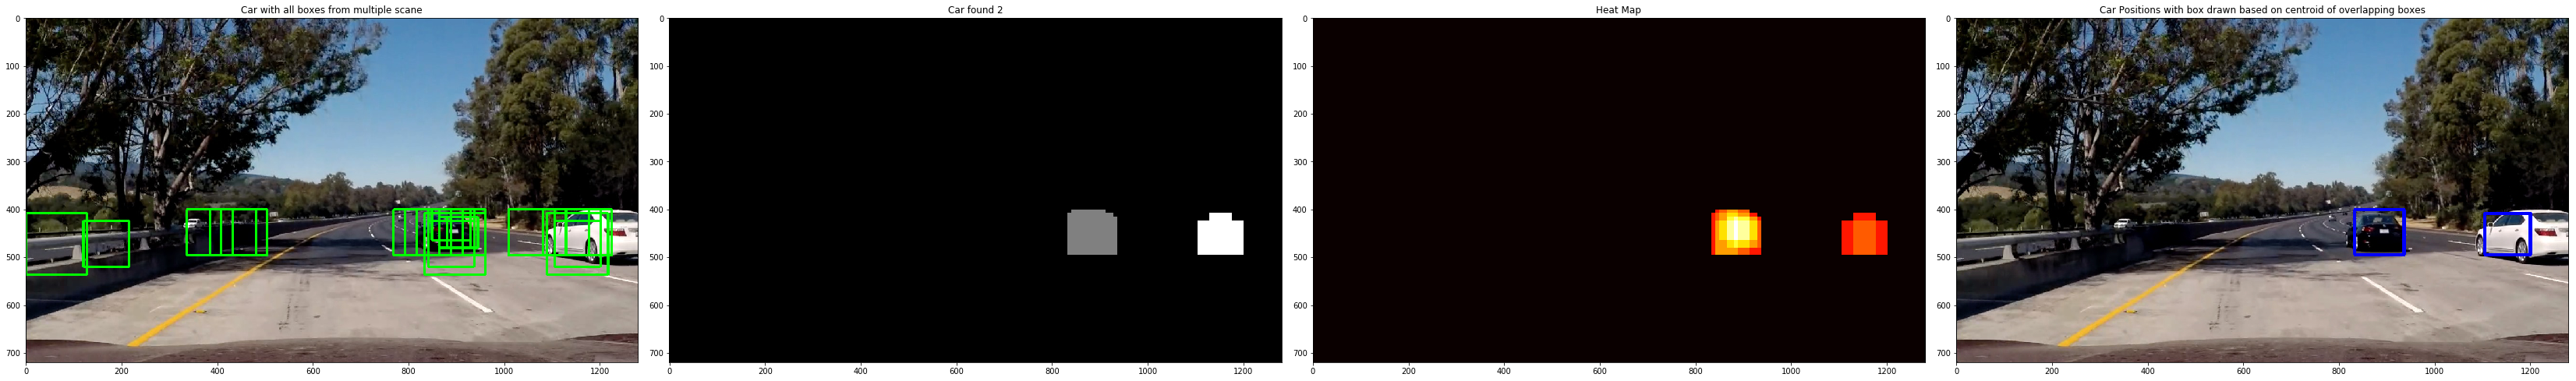

In [37]:
# Read in image similar to one shown above 
pic1 = mpimg.imread(test_car_images[4])
heat = np.zeros_like(pic1[:,:,0]).astype(np.float)
bbox_list = []
cp_image = np.copy(pic1)

# Draw Blue boxs with a scale of 1.5
# middle frames
ystart = 400
ystop = 656
scale = 1.5

windows = find_cars(cp_image, ystart, ystop, scale, clf, X_scaler, orient, \
                pix_per_cell, cell_per_block, spatial_size, hist_bins)

if len(windows) > 0:
    bbox_list.append(windows)


# Draw Red boxs with a scale of 2
# Closer frames with bigger scale i.e 2
ystart = 408
ystop = 656
scale = 2
windows = find_cars(cp_image, ystart, ystop, scale, clf, X_scaler, orient, \
                pix_per_cell, cell_per_block, spatial_size, hist_bins)

if len(windows) > 0:
    bbox_list.append(windows)

# Draw Green boxs with a scale of 1
# Frames in far with lower scale i.e. 1
ystart = 400
ystop = 500
scale = 1
windows = find_cars(cp_image, ystart, ystop, scale, clf, X_scaler, orient, \
                pix_per_cell, cell_per_block, spatial_size, hist_bins)

if len(windows) > 0:
    bbox_list.append(windows)

if len(bbox_list) > 0:
    for boxes in bbox_list:
        for box in boxes:
            cv2.rectangle(cp_image, box[0], box[1],(0,255,0),3)

# Add heat to each box in box list
heat = add_heat(heat, bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(pic1), labels)

fig = plt.figure(figsize=(46,46))
plt.subplot(141)
plt.imshow(cp_image)
plt.title('Car with all boxes from multiple scane')

plt.subplot(142)
plt.imshow(labels[0], cmap='gray')
title = 'Car found %s'%format(labels[1])
plt.title(title)

plt.subplot(143)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

plt.subplot(144)
plt.imshow(draw_img)
plt.title('Car Positions with box drawn based on centroid of overlapping boxes')
fig.tight_layout()

#### Create a Class to store the context over multiple frames

In [38]:
class frame():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        
        self.box_list = []

    '''
         Append the fit coefficient into. If there are more than 5 fit coefficients 
         on current_fit remove the old one (the first one ), fifo/.
         Average the remaining and store it in self.best_fit
    '''
    def add_boxes(self, box):

        self.box_list.append(box)
        if len(self.box_list) > 10:
            self.box_list  = self.box_list[-10:]


#### Video Implementation
Following is the main pipeline that takes each frame from the video, use 3 sliding window with an scale of 1, 1.5 and 2 on far, closer and more closer frames to detect the car and store the detected boxes for last 10 frames, generate heat-map based on this last 10 detected boxes across multiple sliding windows and apply a threshold of 50% and finally draw the boxes on the image and return it.

In [39]:
def pipeline(img):
    
    frames = 0
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    

    ystart = 400
    ystop = 656  
    scale = 1.5
    windows = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, \
                pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(windows) > 0:
        frame_ctx.add_boxes(windows)

        
    
    ystart = 408
    ystop = 656  
    scale = 2
    windows = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, \
            pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(windows) > 0:
        frame_ctx.add_boxes(windows)
    

    ystart = 400
    ystop = 500  
    scale = 1
    
    windows = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, \
            pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(windows) > 0:
        frame_ctx.add_boxes(windows)


    # Add heat to each box in box list
    heat = add_heat(heat,frame_ctx.box_list)
    
    # Apply threshold to help remove false positives
    # I selected the threshold value based on multiple iteration of the track
    # with the above 3 different scale sliding window box detection and visually 
    # observed the True and False frames

    heat = apply_threshold(heat, 1 + len(frame_ctx.box_list)//2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img



def process_image(img):
    output = pipeline(img)
    return output


In [40]:
frame_ctx = frame()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(4, 7)#subclip(7, 12)#subclip(40, 42)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [16:03<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 15min 38s, sys: 38.8 s, total: 16min 17s
Wall time: 16min 3s



#### Discussion

####1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

There are some false positive (which I do not consider to be false) as those cars are comming from the other direction (on the left) and I could have used the xstart to regulate the starting of the sliding windows in X direction to filterout those detection or detect the lane line as in previous project and ignore any detection outside of the lane line but that will not be practicle as I think this is important to detect anything along the x axis even if they are outside of the lane. 

I could have use more sliding windows to make the bounded box more stable but just wanted to make it simple for now.

I could have calculate the centroid of each detected boxes per frame, measure the distance of these centroids among the boxes near the same location (with some += mergin) over few frames and can estimate the projected distance of the same box(car) on the next upcomming frame and draw it and could make the pipeline faster as was suggested in the course video. But that should also take into consideration the fact that car passing my car can slow down and in next frame it may appear closer as oppose to farther.

I coud have shown the number of car detected (labels[1]) based on heatmap & before and after applying threshold in realtime to make the video more predictable about the pipeline, also could have implemented a dynamic sliding window where  more scanning will be done when there is a change in the number of detection and apply even a harder threshold in this transient time to ignore the false positive etc with a firm detection.


